# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [156]:
!export PATH=/Library/TeX/texbin:$PATH


In [8]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [9]:
#load data into dataframe using pandas
train_data = pd.read_csv('data_sentiment/train.csv',header=None)

train_data.columns=['raw_text','label']

test_data = pd.read_csv('data_sentiment/test.csv',header=None)

test_data.columns=['raw_text','label']

dev_data = pd.read_csv('data_sentiment/dev.csv',header=None)

dev_data.columns=['raw_text','label']


In [10]:
train_data.head()

,raw_text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


In [11]:
test_data.head()

,raw_text,label
0,wild things is a suspenseful thriller starring...,1
1,"i know it already opened in december , but i f...",1
2,"what's shocking about "" carlito's way "" is how...",1
3,uncompromising french director robert bresson'...,1
4,"aggressive , bleak , and unrelenting film abou...",1


In [12]:
dev_data.head()

,raw_text,label
0,"if he doesn=92t watch out , mel gibson is in d...",1
1,"wong kar-wei's "" fallen angels "" is , on a pur...",1
2,there is nothing like american history x in th...,1
3,"an unhappy italian housewife , a lonely waiter...",1
4,"when people are talking about good old times ,...",1


If you use Pandas you can see a sample of the data.

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [13]:
#converting the data to list and labels to numpy array

train_text = train_data['raw_text'].tolist()
train_labels = train_data['label'].to_numpy()
test_text = test_data['raw_text'].tolist()
test_labels = test_data['label'].to_numpy()
dev_text = dev_data['raw_text'].tolist()
dev_labels = dev_data['label'].to_numpy()


# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [14]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

In [15]:
#Train Data preprocessing
x_raw_train=[]
x_raw_test=[]
x_raw_dev=[]
x_raw_train_char=[]
x_raw_test_char=[]
x_raw_dev_char=[]
for i in range(0,len(train_data)):
    y=train_data['raw_text'][i]
#replace special characters with space for word ngrams
    x_raw = re.sub(r'[^a-zA-Z0-9\s]', ' ', y)
#just remove \ symbol because it has no meaning (i have left the other special characters as 
#they have some meaning in char ngrams)
    x_raw_char = re.sub(r'\+','',y)
    x_raw_train_char.append(x_raw_char)
#replace mulitple spaces with single space for word ngrams
    x_raw_t = re.sub(r' +',' ',x_raw)
    x_raw_train.append(x_raw_t)
   


 #Dev Data preprocessing
for i in range(0,len(dev_data)):
    y=dev_data['raw_text'][i]

#replace special characters with space
    x_raw = re.sub(r'[^a-zA-Z0-9\s]', ' ', y)
#just remove \ symbol because it has no meaning (i have left the other special characters as 
#they have some meaning in char ngrams)
    x_raw_char = re.sub(r'\+','',y)
    x_raw_test_char.append(x_raw_char)
#replace mulitple spaces with single space
    x_raw_d = re.sub(r' +',' ',x_raw)
    x_raw_dev.append(x_raw_d)

    
    
#test Data preprocessing
for i in range(0,len(test_data)):
    y=test_data['raw_text'][i]

#replace special characters with space
    x_raw = re.sub(r'[^a-zA-Z0-9\s]', ' ', y)
#just remove \ symbol because it has no meaning (i have left the other special characters as 
#they have some meaning in char ngrams)
    x_raw_char = re.sub(r'\+','',y)
    x_raw_dev_char.append(x_raw_char)
#replace mulitple spaces with single space
    x_raw_t = re.sub(r' +',' ',x_raw)
    x_raw_test.append(x_raw_t)


### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [16]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r' ', 
                   stop_words=[], vocab=set(), char_ngrams=False):
    #convert to lowercase
    x_raw = x_raw.lower()
    tokens=[]
    tokens_new=[]
    tuple_list=[]
    new_token_list=[]
    sep=' '
  
    
    #Extract character ngrams 
    if char_ngrams==True:
        
        x_raw =re.sub(r' +','',x_raw) 
        for i in range(ngram_range[0],ngram_range[1]+1):
            tokens.extend(x_raw[z:z+i] for z in range(len(x_raw)-i+1))
        extracted_ngrams=tokens
        
    #Extract word ngrams
    else:
        tokens = [token for token in x_raw.split(token_pattern) if token != ""]
    
        x_raw_new = [word for word in tokens if word not in stop_words]

        for i in range(ngram_range[0],ngram_range[1]+1):
            tokens_new.extend(x_raw_new[z:z+i] for z in range(len(x_raw_new)-i+1))

        for i in tokens_new:
            tuple_list.append(tuple(i))
        extracted_ngrams=tuple_list
        
    #return extracted ngrams from given vocabulary or return the full list of ngrams
    return [ngram for ngram in extracted_ngrams if ngram in vocab] if vocab else extracted_ngrams
    
    




Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [ ]:
z=extract_ngrams(x_raw_test[0],
               ngram_range=(1,3),
               stop_words=stop_words,
                vocab=train_vocab,
               char_ngrams=False)

In [12]:
t=extract_ngrams("-- movie", 
               ngram_range=(2,4), 
               stop_words=[],
                 vocab=set(),
               char_ngrams=True)

In [13]:
t

['--',
 '- ',
 ' m',
 'mo',
 'ov',
 'vi',
 'ie',
 '-- ',
 '- m',
 ' mo',
 'mov',
 'ovi',
 'vie',
 '-- m',
 '- mo',
 ' mov',
 'movi',
 'ovie']

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [1]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r' ', 
              min_df=0, keep_topN=0, 
              stop_words=[],char_ngrams=False):
    
    df = Counter()
    ngram_counter = Counter()
    #iterate over the whole list of documents
    for doc in X_raw:
        vocab_list = extract_ngrams(doc,ngram_range=ngram_range,stop_words=stop_words,vocab=set(),char_ngrams=char_ngrams)
        #vocab=vocab_list
        
    
        #calculate document frequency of ngram using counter
        df.update(vocab_list)

        #calculate count of each ngram in vocab
        ngram_counter.update(ngram for ngram in vocab_list if df[ngram]>=min_df)
        
        #Get topN ngrams
        vocab_temp=ngram_counter.most_common(keep_topN)
        
        #create a set of vocabulary of all top N ngrams 
        vocab = {i[0] for i in vocab_temp}
        
    
    #return vocabulary, document frequency, ngram count
    return vocab, df, ngram_counter

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [18]:
train_vocab,train_df,train_ngram_counts = get_vocab(x_raw_train,ngram_range=(1,3),stop_words=stop_words,min_df=1,keep_topN=10000,char_ngrams=False)
_,dev_df, _ = get_vocab(x_raw_dev, keep_topN=10000)
_,test_df, _ = get_vocab(x_raw_test, keep_topN=10000)

create vocab and get document frequencies for char n-grams

In [19]:
train_char_vocab,train_char_df,train_char_counts = get_vocab(x_raw_train_char,ngram_range=(2,6),stop_words=stop_words,min_df=5,keep_topN=10000,char_ngrams=True)
_,dev_char_df, _ = get_vocab(x_raw_dev_char, keep_topN=10000,char_ngrams=True)
_,test_char_df, _ = get_vocab(x_raw_test_char, keep_topN=10000,char_ngrams=True)

Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

i have created another 2 dictionaries that have vocabulary id->chars; and chars-> vocabulary id

In [20]:
#function returns 2 dictionaries with vocab_id -> word and word -> vocab_id 
def vocab2word(vocab):
    v2w={}
    w2v={}
    for idx,word in enumerate(vocab):
        v2w[idx]=word
        w2v[word]=idx
    #print(v2w)
    
    return v2w,w2v

In [21]:
vocab_word = dict()
word_vocab = dict()
vocab_char={}
char_vocab={}

vocab_word,word_vocab =vocab2word(train_vocab)
vocab_char,char_vocab =vocab2word(train_char_vocab)






Now you should be able to extract n-grams for each text in the training, development and test sets:

In [22]:
train_ngrams_list=[]
train_char_list=[]
test_ngrams_list=[]
test_char_list=[]
dev_ngrams_list=[]
dev_char_list=[]
for doc in x_raw_train:
    train_ngrams_list.append(extract_ngrams(doc,ngram_range=(1,3),token_pattern=r' ',stop_words=stop_words,vocab=train_vocab,char_ngrams=False))
    train_char_list.append(extract_ngrams(doc,ngram_range=(2,6),token_pattern=r' ',stop_words=stop_words,vocab=train_char_vocab,char_ngrams=True))
for doc in x_raw_test:
    test_ngrams_list.append(extract_ngrams(doc,ngram_range=(1,3),token_pattern=r' ',stop_words=stop_words,vocab=train_vocab,char_ngrams=False))
    test_char_list.append(extract_ngrams(doc,ngram_range=(2,6),token_pattern=r' ',stop_words=stop_words,vocab=train_char_vocab,char_ngrams=True))
for doc in x_raw_dev:
    dev_ngrams_list.append(extract_ngrams(doc,ngram_range=(1,3),token_pattern=r' ',stop_words=stop_words,vocab=train_vocab,char_ngrams=False))
    dev_char_list.append(extract_ngrams(doc,ngram_range=(2,6),token_pattern=r' ',stop_words=stop_words,vocab=train_char_vocab,char_ngrams=True))


    
                           

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [23]:
def vectorise(X_ngram, vocab ):
    final_vector=[]
    print('number of documents',len(X_ngram))
    
    #iterate through the list of ngrams_list
    for doc_ngram in X_ngram:
        #use counter to get count of vocab word if present in document
        count = Counter(doc_ngram)
        temp_vector=[]
        for ngram in vocab:
            temp_vector.extend([count[ngram]])
        final_vector.append(temp_vector)
    X_vec = np.array(final_vector)
    return X_vec
    
    
    


Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [24]:
#create 
train_count_vector = vectorise(train_ngrams_list,train_vocab)
train_char_count_vector = vectorise(train_char_list,train_char_vocab)
test_count_vector = vectorise(test_ngrams_list,train_vocab)
test_char_count_vector = vectorise(test_char_list,train_char_vocab)
dev_count_vector = vectorise(dev_ngrams_list,train_vocab)
dev_char_count_vector = vectorise(dev_char_list,train_char_vocab)

number of documents 1400
number of documents 1400
number of documents 400
number of documents 400
number of documents 200
number of documents 200


In [25]:
print("shape of train data vector -",train_count_vector.shape," shape of test data vector -",test_count_vector.shape,"\nshape of validation data vector -",dev_count_vector.shape)

shape of train data vector - (1400, 10000)  shape of test data vector - (400, 10000) 
shape of validation data vector - (200, 10000)


#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [26]:
#compute the IDF of training,test and validation set of BOW

temp_arr=[]
temp_arr2=[]
temp_arr3=[]
for v in train_vocab:
    temp_arr.append(np.log10(len(x_raw_train)/(train_df[v]+1)))
    temp_arr2.append(np.log10(len(x_raw_test)/(test_df[v]+1)))
    temp_arr3.append(np.log10(len(x_raw_dev)/(dev_df[v]+1)))


train_idf=np.array(temp_arr)
test_idf = np.array(temp_arr2)
dev_idf = np.array(temp_arr3)

#compute the IDF of training,test and validation set of BOCN
temp_arr=[]
temp_arr2=[]
temp_arr3=[]
for v in train_char_vocab:
    temp_arr.append(np.log10(len(x_raw_train)/(train_char_df[v]+1)))
    temp_arr2.append(np.log10(len(x_raw_test)/(test_char_df[v]+1)))
    temp_arr3.append(np.log10(len(x_raw_dev)/(dev_char_df[v]+1)))

train_char_idf=np.array(temp_arr)
test_char_idf = np.array(temp_arr2)
dev_char_idf = np.array(temp_arr3)





### i have decided to do use smoothing to avoid division by zero in cases

Then transform your count vectors to tf.idf vectors:

In [27]:
train_tf_idf = np.log10(1+train_count_vector) * train_idf
test_tf_idf = np.log10(1+test_count_vector) * test_idf
dev_tf_idf = np.log10(1+dev_count_vector) * dev_idf

train_char_tf_idf = np.log10(1+train_char_count_vector) * train_char_idf
test_char_tf_idf = np.log10(1+test_char_count_vector) * test_char_idf
dev_char_tf_idf = np.log10(1+dev_char_count_vector) * dev_char_idf

In [28]:
train_char_tf_idf.shape

(1400, 10000)

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [29]:
import math
def sigmoid(z):
    sig = 1 / (1 + np.exp(-z))
    
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [30]:
def predict_proba(X, weights):
    
    z = np.dot(X,weights)
    
    preds_proba=sigmoid(z)
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [31]:
def predict_class(X, weights):
    
    preds_class = predict_proba(X,weights)
    
    return [0 if prob<0.5 else 1 for prob in preds_class]

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [32]:
epsilon = 1e-5   
def binary_loss(X, Y, weights, alpha=0.00001):
    '''
    Binary Cross-entropy Loss

    X:(len(X),len(vocab))
    Y: array len(Y)
    weights: array len(X)
    '''
    predicted_prob = predict_proba(X, weights)

    l = -Y * np.log(predicted_prob) - (1 - Y) * np.log(1 - predicted_prob + epsilon  )
    
    l += alpha * weights.dot(weights)
    
    return np.mean(l)
    



Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)

In [33]:
#function to compute gradient with respect to weights
def gradient_dw(x,y,w,alpha,N):
  
    dw = x * (y - (predict_proba(x,w)) - (alpha / N) * w)
    return dw

In [34]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, 
        alpha=0.00001, epochs=5, 
        tolerance=0.0001, print_progress=True):
    np.random.seed(123)
    
    n=X_tr.shape[0] #Samples
    m=X_tr.shape[1] #Features
    training_loss_history = []
    validation_loss_history = []
    

    #initialize weights randomly from standard normal distribution 
    #weights = np.random.randn(X_tr.shape[1])
    weights = np.zeros(X_tr.shape[1])
    #print(weights)
    train_docs = list(zip(X_tr, Y_tr))
    
    #print(train_docs[0][1])
    for current_iteration in np.arange(epochs):

        temp=[]
        np.random.shuffle(train_docs)
        
 
        for x,y in train_docs:
            #calculate gradient for x and y
            dw=gradient_dw(x,y,weights,alpha,n)
            weights = weights + (lr * dw)
            
            
        cur_loss_tr = binary_loss(X_tr, Y_tr, weights, alpha)
        cur_loss_dev = binary_loss(X_dev, Y_dev, weights, alpha)
        
        #stop SGD if the difference in validation loss is lower than tolerance set
        if current_iteration > 0 and validation_loss_history[-1] - cur_loss_dev < tolerance:
            break
        else:
            training_loss_history.append(cur_loss_tr)
            validation_loss_history.append(cur_loss_dev)
        
        if print_progress:
            print(f'Epoch: {current_iteration:{10}} | Training loss: {cur_loss_tr:{15}} | Validation loss: {cur_loss_dev:{15}}')
        

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [161]:
#generate hyperparameters using logspace
lr = np.linspace(0.00001, 0.01, num = 5,endpoint=False)
alpha = np.logspace(-5, -1, num = 5,endpoint=False)


In [162]:
lr

array([1.000e-05, 2.008e-03, 4.006e-03, 6.004e-03, 8.002e-03])

In [163]:
alpha

array([1.00000000e-05, 6.30957344e-05, 3.98107171e-04, 2.51188643e-03,
       1.58489319e-02])

In [164]:
#hyper paramater tuning for BOW-Count
train_loss_history =[]
validation_loss_history=[]
hyperparam_history=[]
#
for lr_i in lr:
    for alpha_i in alpha:
        print('\nHyper Parameters -- Learning Rate -',lr_i,' Regularization Parameter-',alpha_i)
        weight, train_loss_count, dev_loss_count = SGD(X_tr=train_count_vector,
                                             Y_tr=train_labels,
                                             X_dev=dev_count_vector,
                                             Y_dev=dev_labels,
                                             lr=lr_i,
                                             alpha=alpha_i,
                                             tolerance=0.0001,
                                             epochs=400,
                                             print_progress=False)
        if len(train_loss_count) > 40:
            train_loss_history.append(train_loss_count[-1])
            validation_loss_history.append(dev_loss_count[-1])
            hyperparam_history.append([lr_i,alpha_i])
     


        


Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 1e-05

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 6.309573444801929e-05

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 0.00039810717055349735

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 0.002511886431509582

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 0.01584893192461114

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 1e-05

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 6.309573444801929e-05

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 0.00039810717055349735

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 0.002511886431509582

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 0.01584893192461114

Hyper Parameters -- Learning Rate -

In [165]:
#get the best hyper parameters
temp = np.array(train_loss_history)
train_loss_history_sortidx = np.argsort(temp)

best_train_loss = temp[train_loss_history_sortidx[0]]
best_validation_loss = validation_loss_history[train_loss_history_sortidx[0]]
best_hyperparams=hyperparam_history[train_loss_history_sortidx[0]]

print(f'Best Training loss - {best_train_loss},best_validation_loss-{best_validation_loss},\nbest_hyperparams-{best_hyperparams}')



Best Training loss - 0.23281265732113487,best_validation_loss-0.41329350790053354,
best_hyperparams-[1e-05, 1e-05]


In [166]:
weight, train_loss_count, dev_loss_count = SGD(X_tr=train_count_vector,
                                             Y_tr=train_labels,
                                             X_dev=dev_count_vector,
                                             Y_dev=dev_labels,
                                             lr=best_hyperparams[0],
                                             alpha=best_hyperparams[1],
                                             tolerance=0.00001,
                                             epochs=500,
                                             print_progress=True)

Epoch:          0 | Training loss: 0.6837664802935786 | Validation loss: 0.6860666266246024
Epoch:          1 | Training loss: 0.6751537941301965 | Validation loss: 0.6800242919507538
Epoch:          2 | Training loss: 0.6670410843190909 | Validation loss: 0.6741665937070213
Epoch:          3 | Training loss: 0.6593693831021286 | Validation loss: 0.6688284403248014
Epoch:          4 | Training loss: 0.6520789507389164 | Validation loss: 0.6642044718900759
Epoch:          5 | Training loss: 0.6451418867290613 | Validation loss: 0.6592676317437978
Epoch:          6 | Training loss: 0.6385578999155843 | Validation loss: 0.6546807321249714
Epoch:          7 | Training loss: 0.6322596420878759 | Validation loss: 0.6507759296929874
Epoch:          8 | Training loss: 0.6262314087264625 | Validation loss: 0.646674831896937
Epoch:          9 | Training loss: 0.620460854628425 | Validation loss: 0.64272630178654
Epoch:         10 | Training loss: 0.6149881618632875 | Validation loss: 0.639473854

Epoch:         90 | Training loss: 0.4172757794162526 | Validation loss: 0.5151131850544521
Epoch:         91 | Training loss: 0.4159762832232861 | Validation loss: 0.5140810545242347
Epoch:         92 | Training loss: 0.41464340331998195 | Validation loss: 0.5134520424238438
Epoch:         93 | Training loss: 0.4133468123738284 | Validation loss: 0.5128286890702466
Epoch:         94 | Training loss: 0.4120585401784717 | Validation loss: 0.5118623067546063
Epoch:         95 | Training loss: 0.4107899160380053 | Validation loss: 0.5110190277209037
Epoch:         96 | Training loss: 0.4095229318181874 | Validation loss: 0.5105047904426872
Epoch:         97 | Training loss: 0.40826756001931724 | Validation loss: 0.5095879179310288
Epoch:         98 | Training loss: 0.4070266603437674 | Validation loss: 0.5088495815583657
Epoch:         99 | Training loss: 0.40580129879378796 | Validation loss: 0.5082373370727296
Epoch:        100 | Training loss: 0.4045811907223099 | Validation loss: 0.50

Epoch:        179 | Training loss: 0.33221217814564225 | Validation loss: 0.4646831356370877
Epoch:        180 | Training loss: 0.33151099935248435 | Validation loss: 0.4643300041296846
Epoch:        181 | Training loss: 0.33081210232163055 | Validation loss: 0.4638747885329552
Epoch:        182 | Training loss: 0.33011805846000997 | Validation loss: 0.4635279741292131
Epoch:        183 | Training loss: 0.3294272036932456 | Validation loss: 0.46309147136694834
Epoch:        184 | Training loss: 0.32874422459478614 | Validation loss: 0.4628154395085077
Epoch:        185 | Training loss: 0.32805709022503043 | Validation loss: 0.4623556638684647
Epoch:        186 | Training loss: 0.32737747565202324 | Validation loss: 0.461940278786045
Epoch:        187 | Training loss: 0.32670557530677463 | Validation loss: 0.4614888647627559
Epoch:        188 | Training loss: 0.3260353060054206 | Validation loss: 0.4610928508119131
Epoch:        189 | Training loss: 0.3253700076164875 | Validation loss:

Epoch:        268 | Training loss: 0.28149609523660174 | Validation loss: 0.43705884675505446
Epoch:        269 | Training loss: 0.2810311151075112 | Validation loss: 0.4368383014770363
Epoch:        270 | Training loss: 0.28056912719671784 | Validation loss: 0.43658948063331693
Epoch:        271 | Training loss: 0.28011015575631687 | Validation loss: 0.4364321913654545
Epoch:        272 | Training loss: 0.27964962055397224 | Validation loss: 0.4361481172851967
Epoch:        273 | Training loss: 0.2791927882589598 | Validation loss: 0.4359207019412642
Epoch:        274 | Training loss: 0.27873755087120894 | Validation loss: 0.43567979429809156
Epoch:        275 | Training loss: 0.27828454033736877 | Validation loss: 0.43541548329062274
Epoch:        276 | Training loss: 0.27783341316269955 | Validation loss: 0.4352428184030165
Epoch:        277 | Training loss: 0.2773835561583845 | Validation loss: 0.4349407220671337
Epoch:        278 | Training loss: 0.2769346053615126 | Validation lo

Epoch:        358 | Training loss: 0.2458558698624229 | Validation loss: 0.4193471182911409
Epoch:        359 | Training loss: 0.2455165804589985 | Validation loss: 0.4192126506882012
Epoch:        360 | Training loss: 0.24517955844786798 | Validation loss: 0.41906090865577406
Epoch:        361 | Training loss: 0.24484481539464428 | Validation loss: 0.4188719641108787
Epoch:        362 | Training loss: 0.2445101590099968 | Validation loss: 0.41871188342840426
Epoch:        363 | Training loss: 0.24417653031448425 | Validation loss: 0.4185537598580524
Epoch:        364 | Training loss: 0.24384283170198784 | Validation loss: 0.41841451014062003
Epoch:        365 | Training loss: 0.24351089762153735 | Validation loss: 0.41827779821206845
Epoch:        366 | Training loss: 0.24318093854283263 | Validation loss: 0.4181452851955499
Epoch:        367 | Training loss: 0.2428508526968094 | Validation loss: 0.4179770220448924
Epoch:        368 | Training loss: 0.24252224267584455 | Validation lo

Epoch:        448 | Training loss: 0.21912091496029498 | Validation loss: 0.40718057663716634
Epoch:        449 | Training loss: 0.21885999419925334 | Validation loss: 0.40706495675263
Epoch:        450 | Training loss: 0.21859952828562224 | Validation loss: 0.40694336945652976
Epoch:        451 | Training loss: 0.21834029345426975 | Validation loss: 0.4068377678530383
Epoch:        452 | Training loss: 0.21808134076779062 | Validation loss: 0.406691713827346
Epoch:        453 | Training loss: 0.21782310367567237 | Validation loss: 0.4065816102267918
Epoch:        454 | Training loss: 0.2175656833106895 | Validation loss: 0.40646754676537133
Epoch:        455 | Training loss: 0.217308975111601 | Validation loss: 0.40638406021940626
Epoch:        456 | Training loss: 0.2170546879049753 | Validation loss: 0.4062178157201805
Epoch:        457 | Training loss: 0.21679780830955442 | Validation loss: 0.406122533552396
Epoch:        458 | Training loss: 0.21654235153805432 | Validation loss: 

Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

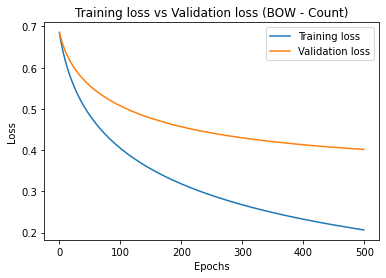

In [167]:
plt.plot(train_loss_count, label='Training loss')
plt.plot(dev_loss_count, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training loss vs Validation loss (BOW - Count)')

plt.legend()

plt.show()

Explain here...

#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [42]:
preds_te_count = predict_class(test_count_vector, weight)

print('Accuracy:', accuracy_score(test_labels,preds_te_count))
print('Precision:', precision_score(test_labels,preds_te_count))
print('Recall:', recall_score(test_labels,preds_te_count))
print('F1-Score:', f1_score(test_labels,preds_te_count))

Accuracy: 0.845
Precision: 0.8349514563106796
Recall: 0.86
F1-Score: 0.8472906403940887


Finally, print the top-10 words for the negative and positive class respectively.

In [43]:
top_negative_words = weight.argsort()[:10]
for i in top_negative_words:
    print(vocab_word[i])

('bad',)
('only',)
('plot',)
('worst',)
('unfortunately',)
('script',)
('why',)
('boring',)
('nothing',)
('any',)


In [44]:
top_positive_words = weight.argsort()[::-1][:10]
for i in top_positive_words:
    print(vocab_word[i])

('great',)
('well',)
('also',)
('seen',)
('life',)
('world',)
('many',)
('see',)
('very',)
('fun',)


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

#### This classifier is trained on movie reviews data. Word count are the features we used to train this classfier and therefore if we were to apply this classifer in different domain such as laptop review or restaurant review, Most probably it would classify reviews correctly as reviews are either positive or negative, given that reviews are positive if the words used are among the top positive words and negative reviews contain words from top negative words of this classifier.

#### But, Restaurant and laptop reviews use different words to express positive and negative. In case of restaurant reviews,positive words like 'Delicious','Amazing','Welcomed','Cozy','Luxurious','Atmosphere',etc. And negative words like 'Unequipped','Snappy','mediocre',etc. And in case of Laptop reviews,positive words like 'Budget-friendly','fast','productivity','Gaming','Performance',etc. And negative words like 'Unsatisfied','Unhygenic',etc.
#### The above mentioned words are features that can be important in the new domain. I think that this classifier would not generalise well in different domains.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

#### Generated 5 different values using logspace and linspace and trained the model for all 25 different variations and selected the best hyperparameter from the results. From online review i found out that learning rate range is between 0.0001 to 0.01.

#### If learning rate is too high then the cost function will converge very fast or in less epochs which may result in underfitting. if learning rate is too low then the cost function will converge very slow or takes higher epochs. Each epoch results in a larger weight update. Consequently, a higher learning rate will result in fewer convergence epochs.

#### from the above trails, it can observed that tiny changes in the regularization parameter affects the number of epochs required for convergence

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [168]:
#hyper paramater tuning for BOW-tfidf
train_loss_history =[]
validation_loss_history=[]
hyperparam_history=[]
#
for lr_i in lr:
    for alpha_i in alpha:
        print('\nHyper Parameters -- Learning Rate -',lr_i,' Regularization Parameter-',alpha_i)
        weight, train_loss_count, dev_loss_count = SGD(X_tr=train_tf_idf,
                                             Y_tr=train_labels,
                                             X_dev=dev_tf_idf,
                                             Y_dev=dev_labels,
                                             lr=lr_i,
                                             alpha=alpha_i,
                                             tolerance=0.00001,
                                             epochs=800,
                                             print_progress=False)
        if len(train_loss_count) > 40:
            train_loss_history.append(train_loss_count[-1])
            validation_loss_history.append(dev_loss_count[-1])
            hyperparam_history.append([lr_i,alpha_i])
     




Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 1e-05

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 6.309573444801929e-05

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 0.00039810717055349735

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 0.002511886431509582

Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 0.01584893192461114

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 1e-05

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 6.309573444801929e-05

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 0.00039810717055349735

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 0.002511886431509582

Hyper Parameters -- Learning Rate - 0.0020080000000000002  Regularization Parameter- 0.01584893192461114

Hyper Parameters -- Learning Rate -

In [169]:
#get the best hyper parameters
temp = np.array(train_loss_history)
train_loss_history_sortidx = np.argsort(temp)

best_train_loss_BOW_tfidf = temp[train_loss_history_sortidx[0]]
best_validation_loss_BOW_tfidf = validation_loss_history[train_loss_history_sortidx[0]]
best_hyperparams_BOW_tfidf=hyperparam_history[train_loss_history_sortidx[0]]

print("BOW-TFIDF")
print(f'Best Training loss - {best_train_loss_BOW_tfidf},best_validation_loss-{best_validation_loss_BOW_tfidf},\nbest_hyperparams-{best_hyperparams_BOW_tfidf}')



BOW-TFIDF
Best Training loss - 0.01744929454307362,best_validation_loss-0.3313827620476839,
best_hyperparams-[0.008002, 1e-05]


In [170]:
weight_tfidf, train_loss_count_tfidf, dev_loss_count_tfidf = SGD(X_tr=train_tf_idf,
                                             Y_tr=train_labels,
                                             X_dev=dev_tf_idf,
                                             Y_dev=dev_labels,
                                             lr=best_hyperparams_BOW_tfidf[0],
                                             alpha=best_hyperparams_BOW_tfidf[1],
                                             tolerance=0.00001,
                                             epochs=1000,
                                             print_progress=True)

Epoch:          0 | Training loss: 0.5000687628863478 | Validation loss: 0.5943528148320568
Epoch:          1 | Training loss: 0.39920986884994153 | Validation loss: 0.5428902906558546
Epoch:          2 | Training loss: 0.33499138039352355 | Validation loss: 0.508580032542277
Epoch:          3 | Training loss: 0.29000179667592907 | Validation loss: 0.4845671543225173
Epoch:          4 | Training loss: 0.25627014471622933 | Validation loss: 0.46684129906035027
Epoch:          5 | Training loss: 0.2297458089909241 | Validation loss: 0.45205353662995096
Epoch:          6 | Training loss: 0.20825335037158837 | Validation loss: 0.440253446789454
Epoch:          7 | Training loss: 0.19063950647322533 | Validation loss: 0.4307245702563378
Epoch:          8 | Training loss: 0.17571415147854116 | Validation loss: 0.4223184849980601
Epoch:          9 | Training loss: 0.16313514118760217 | Validation loss: 0.4154286345989037
Epoch:         10 | Training loss: 0.15233302691037892 | Validation loss

Epoch:         88 | Training loss: 0.025973306720391248 | Validation loss: 0.334695588240145
Epoch:         89 | Training loss: 0.025736477503264833 | Validation loss: 0.3345627173753212
Epoch:         90 | Training loss: 0.025504439328551183 | Validation loss: 0.33445741962174685
Epoch:         91 | Training loss: 0.025278057005136287 | Validation loss: 0.33433456728305166
Epoch:         92 | Training loss: 0.025055991256853295 | Validation loss: 0.334248096385748
Epoch:         93 | Training loss: 0.02483917047448617 | Validation loss: 0.3341666762470636
Epoch:         94 | Training loss: 0.024627020160449292 | Validation loss: 0.334040682245154
Epoch:         95 | Training loss: 0.024419490226773043 | Validation loss: 0.3339347650191625
Epoch:         96 | Training loss: 0.024216176467809953 | Validation loss: 0.33386107894527284
Epoch:         97 | Training loss: 0.02401729117559786 | Validation loss: 0.3337511055608183
Epoch:         98 | Training loss: 0.023822449933726477 | Vali

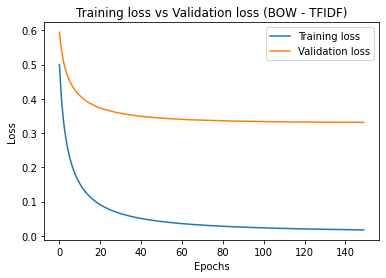

In [171]:
plt.plot(train_loss_count_tfidf, label='Training loss')
plt.plot(dev_loss_count_tfidf, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training loss vs Validation loss (BOW - TFIDF)')

plt.legend()

plt.show()

In [172]:
preds_te_count = predict_class(test_tf_idf, weight)

print('Accuracy:', accuracy_score(test_labels,preds_te_count))
print('Precision:', precision_score(test_labels,preds_te_count))
print('Recall:', recall_score(test_labels,preds_te_count))
print('F1-Score:', f1_score(test_labels,preds_te_count))

Accuracy: 0.855
Precision: 0.8585858585858586
Recall: 0.85
F1-Score: 0.8542713567839195


### Top 10 negative and positive Words from BOW-TFIDF

In [173]:
top_negative_words = weight_tfidf.argsort()[:10]
for i in top_negative_words:
    print(vocab_word[i])

('worst',)
('boring',)
('unfortunately',)
('supposed',)
('waste',)
('ridiculous',)
('awful',)
('poor',)
('fails',)
('minute',)


In [174]:
top_positive_words = weight_tfidf.argsort()[::-1][:10]
for i in top_positive_words:
    print(vocab_word[i])

('hilarious',)
('perfectly',)
('t',)
('memorable',)
('terrific',)
('s', 'life')
('overall',)
('very', 'well')
('excellent',)
('definitely',)


### the top +ve and -ve words seems to be more accurate compared to the BOW-Count

### Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning for each model...

## BOCN - Count

In [52]:
#generate hyperparameters using logspace
lr_c = np.logspace(-7, -4, num = 5)
alpha_c = np.logspace(-6, -3, num = 5)

# lr_c = np.linspace(0.000001, 0.0001, num = 5,endpoint=False)
# alpha_c = np.logspace(-5, -1, num = 5,endpoint=False)

In [53]:
lr_c

array([1.00000000e-07, 5.62341325e-07, 3.16227766e-06, 1.77827941e-05,
       1.00000000e-04])

In [175]:
#hyper paramater tuning for BOCN count
train_loss_history =[]
validation_loss_history=[]
hyperparam_history=[]
#
for lr_i in lr_c:
    for alpha_i in alpha_c:
        print('\nHyper Parameters -- Learning Rate -',lr_i,' Regularization Parameter-',alpha_i)
        weight, train_loss_count, dev_loss_count = SGD(X_tr=train_char_count_vector,
                                             Y_tr=train_labels,
                                             X_dev=dev_char_count_vector,
                                             Y_dev=dev_labels,
                                             lr=lr_i,
                                             alpha=alpha_i,
                                             tolerance=0.00001,
                                             epochs=100,
                                             print_progress=False)
        if len(train_loss_count) > 5:
            train_loss_history.append(train_loss_count[-1])
            validation_loss_history.append(dev_loss_count[-1])
            hyperparam_history.append([lr_i,alpha_i])
     


Hyper Parameters -- Learning Rate - 1e-07  Regularization Parameter- 1e-06

Hyper Parameters -- Learning Rate - 1e-07  Regularization Parameter- 5.623413251903491e-06

Hyper Parameters -- Learning Rate - 1e-07  Regularization Parameter- 3.1622776601683795e-05

Hyper Parameters -- Learning Rate - 1e-07  Regularization Parameter- 0.00017782794100389227

Hyper Parameters -- Learning Rate - 1e-07  Regularization Parameter- 0.001

Hyper Parameters -- Learning Rate - 5.62341325190349e-07  Regularization Parameter- 1e-06

Hyper Parameters -- Learning Rate - 5.62341325190349e-07  Regularization Parameter- 5.623413251903491e-06

Hyper Parameters -- Learning Rate - 5.62341325190349e-07  Regularization Parameter- 3.1622776601683795e-05

Hyper Parameters -- Learning Rate - 5.62341325190349e-07  Regularization Parameter- 0.00017782794100389227

Hyper Parameters -- Learning Rate - 5.62341325190349e-07  Regularization Parameter- 0.001

Hyper Parameters -- Learning Rate - 3.162277660168379e-06  Regul

In [58]:
#get the best hyper parameters
temp = np.array(train_loss_history)
train_loss_history_sortidx = np.argsort(temp)

best_train_loss_BOCN = temp[train_loss_history_sortidx[0]]
best_validation_loss_BOCN = validation_loss_history[train_loss_history_sortidx[0]]
best_hyperparams_BOCN=hyperparam_history[train_loss_history_sortidx[0]]

print("BOCN")
print(f'Best Training loss - {best_train_loss_BOCN},best_validation_loss-{best_validation_loss_BOCN},\nbest_hyperparams-{best_hyperparams_BOCN}')




BOCN
Best Training loss - 0.545651012297725,best_validation_loss-0.5882516831593606,
best_hyperparams-[3.162277660168379e-06, 1e-06]


In [132]:
weight_c, train_loss_count_c, dev_loss_count_c = SGD(X_tr=train_char_count_vector,
                                             Y_tr=train_labels,
                                             X_dev=dev_char_count_vector,
                                             Y_dev=dev_labels,
                                             lr=best_hyperparams_BOCN[0],
                                             alpha=best_hyperparams_BOCN[1],
                                             tolerance=1.0e-06,
                                             epochs=100,
                                             print_progress=True)

Epoch:          0 | Training loss: 0.6542845694411505 | Validation loss: 0.6657195350794239
Epoch:          1 | Training loss: 0.6230437026470058 | Validation loss: 0.6372112595440422
Epoch:          2 | Training loss: 0.5978921883310198 | Validation loss: 0.6188192740618566
Epoch:          3 | Training loss: 0.5837228648604418 | Validation loss: 0.610550383736873
Epoch:          4 | Training loss: 0.5546239444480642 | Validation loss: 0.5889601019749006
Epoch:          5 | Training loss: 0.545651012297725 | Validation loss: 0.5882516831593606


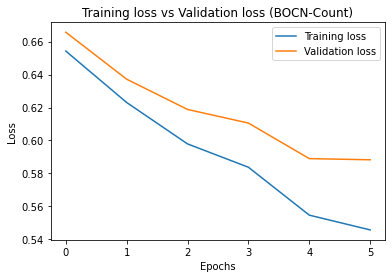

In [133]:
plt.plot(train_loss_count_c, label='Training loss')
plt.plot(dev_loss_count_c, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training loss vs Validation loss (BOCN-Count)')

plt.legend()

plt.show()

In [134]:
preds_te_count = predict_class(test_char_count_vector, weight_c)

print('Accuracy:', accuracy_score(test_labels,preds_te_count))
print('Precision:', precision_score(test_labels,preds_te_count))
print('Recall:', recall_score(test_labels,preds_te_count))
print('F1-Score:', f1_score(test_labels,preds_te_count))

Accuracy: 0.7575
Precision: 0.8601398601398601
Recall: 0.615
F1-Score: 0.7172011661807579


## Top 10 negative and positive characters BOCN (raw)

In [135]:
top_negative_words = weight_c.argsort()[:10]
for i in top_negative_words:
    print(vocab_char[i])

ba
ha
ad
lo
ed
tt
te
oo
nt
in


In [136]:
top_positive_words = weight_c.argsort()[::-1][:10]
for i in top_positive_words:
    print(vocab_char[i])

an
nd
and
is
al
ti
tr
fe
ce
ar


## BOCN - TFIDF

In [138]:
lr_ctf = np.linspace(0.00001, 0.0001, num = 5,endpoint=False)
alpha_ctf = np.logspace(-7, -3, num = 5)


In [75]:
lr_ctf

array([1.0e-05, 2.8e-05, 4.6e-05, 6.4e-05, 8.2e-05])

In [144]:
#hyper paramater tuning for BOCN-tfidf
train_loss_history =[]
validation_loss_history=[]
hyperparam_history=[]
#
for lr_i in lr_ctf:
    for alpha_i in alpha_ctf:
        print('\nHyper Parameters -- Learning Rate -',lr_i,' Regularization Parameter-',alpha_i)
        weight, train_loss_count, dev_loss_count = SGD(X_tr=train_char_tf_idf,
                                             Y_tr=train_labels,
                                             X_dev=dev_char_tf_idf,
                                             Y_dev=dev_labels,
                                             lr=lr_i,
                                             alpha=alpha_i,
                                             tolerance=0.0001,
                                             epochs=300,
                                             print_progress=True)
        if len(train_loss_count) > 5:
            train_loss_history.append(train_loss_count[-1])
            validation_loss_history.append(dev_loss_count[-1])
            hyperparam_history.append([lr_i,alpha_i])


Hyper Parameters -- Learning Rate - 1e-05  Regularization Parameter- 1e-07
Epoch:          0 | Training loss: 0.6923097050658443 | Validation loss: 0.691434878834223
Epoch:          1 | Training loss: 0.6916736978092416 | Validation loss: 0.6902072141306621
Epoch:          2 | Training loss: 0.691041310581203 | Validation loss: 0.6889905217994519
Epoch:          3 | Training loss: 0.6904293177719095 | Validation loss: 0.6878384738718647
Epoch:          4 | Training loss: 0.6898063584677643 | Validation loss: 0.6866520309275623
Epoch:          5 | Training loss: 0.6891657728388537 | Validation loss: 0.6855150351283098
Epoch:          6 | Training loss: 0.6885489178259216 | Validation loss: 0.6844006351054539
Epoch:          7 | Training loss: 0.6879275119448535 | Validation loss: 0.6831700715041151
Epoch:          8 | Training loss: 0.6873171366132588 | Validation loss: 0.6820315145289538
Epoch:          9 | Training loss: 0.6866864582322433 | Validation loss: 0.6809531801897143
Epoch:

Epoch:         12 | Training loss: 0.6848653529634348 | Validation loss: 0.677641178753951
Epoch:         13 | Training loss: 0.6843402996888326 | Validation loss: 0.6764417400492438
Epoch:         14 | Training loss: 0.6836436406566218 | Validation loss: 0.6756962720631384
Epoch:         15 | Training loss: 0.6830409265842201 | Validation loss: 0.6746182156607327
Epoch:         16 | Training loss: 0.6825406159231215 | Validation loss: 0.6732302947574592
Epoch:         17 | Training loss: 0.6818765379653544 | Validation loss: 0.6723271777726376
Epoch:         18 | Training loss: 0.6812502812041953 | Validation loss: 0.6715404517129432
Epoch:         19 | Training loss: 0.6806561471486594 | Validation loss: 0.670591785086592
Epoch:         20 | Training loss: 0.680074925538834 | Validation loss: 0.6694450380595811
Epoch:         21 | Training loss: 0.6794773289210821 | Validation loss: 0.6686050981756952
Epoch:         22 | Training loss: 0.6788902418516957 | Validation loss: 0.66779929

Epoch:          5 | Training loss: 0.6826344795248511 | Validation loss: 0.6743519938876767
Epoch:          6 | Training loss: 0.6809247337901828 | Validation loss: 0.6714347731689472
Epoch:          7 | Training loss: 0.6794061735597072 | Validation loss: 0.6675635810005807
Epoch:          8 | Training loss: 0.6776381340298742 | Validation loss: 0.6651686609699995
Epoch:          9 | Training loss: 0.6760052236568077 | Validation loss: 0.662618696455356
Epoch:         10 | Training loss: 0.675959340205987 | Validation loss: 0.658811927095083
Epoch:         11 | Training loss: 0.672782518213738 | Validation loss: 0.6583244188782209
Epoch:         12 | Training loss: 0.6714089128800269 | Validation loss: 0.6544971635245633
Epoch:         13 | Training loss: 0.670440509092366 | Validation loss: 0.6511298101541014

Hyper Parameters -- Learning Rate - 2.8000000000000003e-05  Regularization Parameter- 0.001
Epoch:          0 | Training loss: 0.6911769513996805 | Validation loss: 0.689230335


Hyper Parameters -- Learning Rate - 6.4e-05  Regularization Parameter- 1e-05
Epoch:          0 | Training loss: 0.6890082921963608 | Validation loss: 0.6852497575485573
Epoch:          1 | Training loss: 0.6850031569722981 | Validation loss: 0.6777608547417715
Epoch:          2 | Training loss: 0.6811454948177134 | Validation loss: 0.6710280941356197

Hyper Parameters -- Learning Rate - 6.4e-05  Regularization Parameter- 0.0001
Epoch:          0 | Training loss: 0.6890083258060601 | Validation loss: 0.685249791159346
Epoch:          1 | Training loss: 0.6850032859427085 | Validation loss: 0.6777609837149818
Epoch:          2 | Training loss: 0.681145781956124 | Validation loss: 0.6710283812801704

Hyper Parameters -- Learning Rate - 6.4e-05  Regularization Parameter- 0.001
Epoch:          0 | Training loss: 0.6890086619030563 | Validation loss: 0.6852501272672363
Epoch:          1 | Training loss: 0.6850045756468457 | Validation loss: 0.6777622734471157
Epoch:          2 | Training lo

In [145]:
#get the best hyper parameters
temp = np.array(train_loss_history)
train_loss_history_sortidx = np.argsort(temp)

best_train_loss_BOCN_tfidf = temp[train_loss_history_sortidx[0]]
best_validation_loss_BOCN_tfidf = validation_loss_history[train_loss_history_sortidx[0]]
best_hyperparams_BOCN_tfidf=hyperparam_history[train_loss_history_sortidx[0]]

print("BOCN-TFIDF")
print(f'Best Training loss - {best_train_loss_BOCN_tfidf},best_validation_loss-{best_validation_loss_BOCN_tfidf},\nbest_hyperparams-{best_hyperparams_BOCN_tfidf}')





BOCN-TFIDF
Best Training loss - 0.6672305745449177,best_validation_loss-0.6402276905337101,
best_hyperparams-[4.6e-05, 1e-07]


In [146]:
#train with best hyperparameters (BOCN-TFIDF)
weight_c, train_loss_count_c, dev_loss_count_c = SGD(X_tr=train_char_tf_idf,
                                             Y_tr=train_labels,
                                             X_dev=dev_char_tf_idf,
                                             Y_dev=dev_labels,
                                             lr=best_hyperparams_BOCN_tfidf[0],
                                             alpha=best_hyperparams_BOCN_tfidf[1],
                                             tolerance=0.0001,
                                             epochs=100,
                                             print_progress=True)

Epoch:          0 | Training loss: 0.6900790098050679 | Validation loss: 0.6871827744568333
Epoch:          1 | Training loss: 0.6872174250479163 | Validation loss: 0.6817711670025566
Epoch:          2 | Training loss: 0.6843560621607965 | Validation loss: 0.6768177359618249
Epoch:          3 | Training loss: 0.6830128733192897 | Validation loss: 0.6763484371630406
Epoch:          4 | Training loss: 0.6790357884514501 | Validation loss: 0.6688415989723484
Epoch:          5 | Training loss: 0.6762455022731914 | Validation loss: 0.6640660622376228
Epoch:          6 | Training loss: 0.6735817563265669 | Validation loss: 0.6598601120989158
Epoch:          7 | Training loss: 0.6712934753988162 | Validation loss: 0.6538210618384803
Epoch:          8 | Training loss: 0.6684378957921223 | Validation loss: 0.6514233864062866
Epoch:          9 | Training loss: 0.6660262696743723 | Validation loss: 0.64696418932815
Epoch:         10 | Training loss: 0.6672305745449177 | Validation loss: 0.6402276

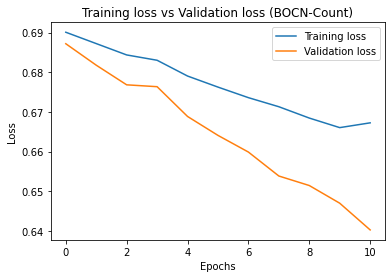

In [147]:
plt.plot(train_loss_count_c, label='Training loss')
plt.plot(dev_loss_count_c, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training loss vs Validation loss (BOCN-Count)')

plt.legend()

plt.show()

In [148]:
preds_te_count = predict_class(test_char_tf_idf, weight_c)

print('Accuracy:', accuracy_score(test_labels,preds_te_count))
print('Precision:', precision_score(test_labels,preds_te_count))
print('Recall:', recall_score(test_labels,preds_te_count))
print('F1-Score:', f1_score(test_labels,preds_te_count))

Accuracy: 0.65
Precision: 0.5920245398773006
Recall: 0.965
F1-Score: 0.7338403041825096


### Top 10 Negative and Positive Characters BOCN(TFIDF)

In [149]:
top_negative_words = weight_c.argsort()[:10]
for i in top_negative_words:
    print(vocab_char[i])

fe
and
tr
per
ion
wors
tio
rf
tion
man


In [150]:
top_positive_words = weight_c.argsort()[::-1][:10]
for i in top_positive_words:
    print(vocab_char[i])

th
ba
ha
he
tt
in
thi
oo
to
ad


## BOW+BOCN

In [103]:
#i have joined the BOW count vector with BOCN count vector and labels using hstack and vstack

#training data
train_BOW_BOCN_count_vector = np.vstack((train_count_vector,train_char_count_vector))

print('new train data array with BOW and BOCN count -',train_BOW_BOCN_count_vector.shape)

train_labels_new = np.hstack((train_labels,train_labels))

print('new array with train labels -',train_labels_new.shape)

#testing data
test_BOW_BOCN_count_vector = np.vstack((test_count_vector,test_char_count_vector))

print('new test data array with BOW and BOCN count -',test_BOW_BOCN_count_vector.shape)

test_labels_new = np.hstack((test_labels,test_labels))

print('new array with train labels -',test_labels_new.shape)

#validation data
dev_BOW_BOCN_count_vector = np.vstack((dev_count_vector,dev_char_count_vector))

print('new validation data array with BOW and BOCN count -',dev_BOW_BOCN_count_vector.shape)

dev_labels_new = np.hstack((dev_labels,dev_labels))

print('new array with train labels -',dev_labels_new.shape)

new train data array with BOW and BOCN count - (2800, 10000)
new array with train labels - (2800,)
new test data array with BOW and BOCN count - (800, 10000)
new array with train labels - (800,)
new validation data array with BOW and BOCN count - (400, 10000)
new array with train labels - (400,)


In [109]:
lr = np.logspace(-7, -4, num = 5)
alpha = np.logspace(-6, -3, num = 5)



In [151]:
#hyper paramater tuning for BOW-Count
train_loss_history =[]
validation_loss_history=[]
hyperparam_history=[]
#
for lr_i in lr:
    for alpha_i in alpha:
        print('\nHyper Parameters -- Learning Rate -',lr_i,' Regularization Parameter-',alpha_i)
        weight, train_loss_count, dev_loss_count = SGD(X_tr=train_BOW_BOCN_count_vector,
                                             Y_tr=train_labels_new,
                                             X_dev=dev_BOW_BOCN_count_vector,
                                             Y_dev=dev_labels_new,
                                             lr=lr_i,
                                             alpha=alpha_i,
                                             tolerance=0.0001,
                                             epochs=400,
                                             print_progress=True)
        if len(train_loss_count) > 5:
            train_loss_history.append(train_loss_count[-1])
            validation_loss_history.append(dev_loss_count[-1])
            hyperparam_history.append([lr_i,alpha_i])
     


        


Hyper Parameters -- Learning Rate - 1e-07  Regularization Parameter- 1e-06
Epoch:          0 | Training loss: 0.6914988723371794 | Validation loss: 0.6910366921400016
Epoch:          1 | Training loss: 0.6906433838251786 | Validation loss: 0.6901687257731097
Epoch:          2 | Training loss: 0.6898480819482578 | Validation loss: 0.6899762427117031
Epoch:          3 | Training loss: 0.6889836180180043 | Validation loss: 0.6887675108274282
Epoch:          4 | Training loss: 0.6880862299850675 | Validation loss: 0.6885030132963333
Epoch:          5 | Training loss: 0.6872352692115632 | Validation loss: 0.687810926729751
Epoch:          6 | Training loss: 0.6864495400645508 | Validation loss: 0.6872754463998534
Epoch:          7 | Training loss: 0.6855515977152251 | Validation loss: 0.6863246072840837
Epoch:          8 | Training loss: 0.6847501892085522 | Validation loss: 0.6856497560338164
Epoch:          9 | Training loss: 0.6839519394798088 | Validation loss: 0.6850338510460636
Epoch


Hyper Parameters -- Learning Rate - 5.62341325190349e-07  Regularization Parameter- 5.623413251903491e-06
Epoch:          0 | Training loss: 0.6875404071057634 | Validation loss: 0.6880718503020578
Epoch:          1 | Training loss: 0.682936215501301 | Validation loss: 0.6843329132090143
Epoch:          2 | Training loss: 0.6795681515937906 | Validation loss: 0.6826076231954704
Epoch:          3 | Training loss: 0.6762240416723949 | Validation loss: 0.6784852307425561

Hyper Parameters -- Learning Rate - 5.62341325190349e-07  Regularization Parameter- 3.1622776601683795e-05
Epoch:          0 | Training loss: 0.6875404073088509 | Validation loss: 0.6880718505051039
Epoch:          1 | Training loss: 0.6829362162826 | Validation loss: 0.6843329139901126
Epoch:          2 | Training loss: 0.6795681532895718 | Validation loss: 0.6826076248907443
Epoch:          3 | Training loss: 0.6762240446028402 | Validation loss: 0.6784852336721312

Hyper Parameters -- Learning Rate - 5.62341325190349

In [152]:
#get the best hyper parameters
temp = np.array(train_loss_history)
train_loss_history_sortidx = np.argsort(temp)

best_train_loss_BOW_BOCN = temp[train_loss_history_sortidx[0]]
best_validation_loss_BOW_BOCN = validation_loss_history[train_loss_history_sortidx[0]]
best_hyperparams_BOW_BOCN=hyperparam_history[train_loss_history_sortidx[0]]

print("BOW-BOCN Count")
print(f'Best Training loss - {best_train_loss_BOCN_tfidf},best_validation_loss-{best_validation_loss_BOCN_tfidf},\nbest_hyperparams-{best_hyperparams_BOCN_tfidf}')




BOW-BOCN Count
Best Training loss - 0.6672305745449177,best_validation_loss-0.6402276905337101,
best_hyperparams-[4.6e-05, 1e-07]


In [153]:
#train with best hyperparameters (BOW-BOCN)
weight_c, train_loss_count_c, dev_loss_count_c = SGD(X_tr=train_BOW_BOCN_count_vector,
                                             Y_tr=train_labels_new,
                                             X_dev=dev_BOW_BOCN_count_vector,
                                             Y_dev=dev_labels_new,
                                             lr=best_hyperparams_BOW_BOCN[0],
                                             alpha=best_hyperparams_BOW_BOCN[1],
                                             tolerance=0.00001,
                                             epochs=100,
                                             print_progress=True)

Epoch:          0 | Training loss: 0.6914988723371794 | Validation loss: 0.6910366921400016
Epoch:          1 | Training loss: 0.6906433838251786 | Validation loss: 0.6901687257731097
Epoch:          2 | Training loss: 0.6898480819482578 | Validation loss: 0.6899762427117031
Epoch:          3 | Training loss: 0.6889836180180043 | Validation loss: 0.6887675108274282
Epoch:          4 | Training loss: 0.6880862299850675 | Validation loss: 0.6885030132963333
Epoch:          5 | Training loss: 0.6872352692115632 | Validation loss: 0.687810926729751
Epoch:          6 | Training loss: 0.6864495400645508 | Validation loss: 0.6872754463998534
Epoch:          7 | Training loss: 0.6855515977152251 | Validation loss: 0.6863246072840837
Epoch:          8 | Training loss: 0.6847501892085522 | Validation loss: 0.6856497560338164
Epoch:          9 | Training loss: 0.6839519394798088 | Validation loss: 0.6850338510460636
Epoch:         10 | Training loss: 0.6831849832516707 | Validation loss: 0.684616

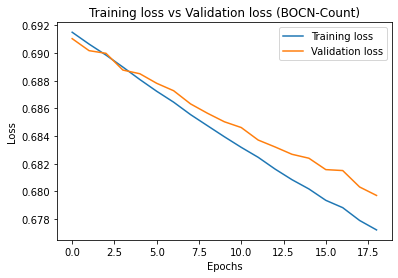

In [154]:
plt.plot(train_loss_count_c, label='Training loss')
plt.plot(dev_loss_count_c, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training loss vs Validation loss (BOCN-Count)')

plt.legend()

plt.show()

In [155]:
preds_te_count = predict_class(test_BOW_BOCN_count_vector, weight_c)
print('Accuracy:', accuracy_score(test_labels_new,preds_te_count))
print('Precision:', precision_score(test_labels_new,preds_te_count))
print('Recall:', recall_score(test_labels_new,preds_te_count))
print('F1-Score:', f1_score(test_labels_new,preds_te_count))

Accuracy: 0.6275
Precision: 0.580952380952381
Recall: 0.915
F1-Score: 0.7106796116504853




## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.8349  | 0.834  | 0.8472  |
| BOW-tfidf  | 0.8585  | 0.85  |  0.8542 |
| BOCN-count  | 0.6775  | 0.935  | 0.7857  |
| BOCN-tfidf  |0.5941   |0.965  |  0.7391 |
| BOW+BOCN  | 0.5809  | 0.915  | 0.7106  |

Please discuss why your best performing model is better than the rest.

#### Based on the observations, BOW-tfidf is the best performing model out of all the models trained. The precision score is 0.8585 = 85.85% and Recall is 0.85. 

#### The model's performance is better than the other models because it is trained on ngrams model (unigram,bigram,trigram) with TFIDF weighting. we know that TFIDF performs better than raw frequencies in most of the cases. The BOCN models (count and TFIDF) worse than the BOW models. The BOW+BOCN(raw) model has the worst precision among the models. On contrary, BOW-TFIDF has the highest precision.

